In [17]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13CH2'
os.chdir(new_path)


In [54]:
from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms,cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy
import matplotlib.pyplot as plt

### Helper functions

In [19]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


In [30]:
def create_embedded_matrices(H, S, index_active_region):
    """
    Create H_embedded and S_embedded matrices based on the active region indices.

    Parameters:
    - H: Hamiltonian matrix (numpy array)
    - S: Overlap matrix (numpy array)
    - index_active_region: List of indices that correspond to the active region.

    Returns:
    - H_embedded: Embedded Hamiltonian matrix
    - S_embedded: Embedded overlap matrix
    """
    # Convert the index of the active region to a set for quick lookup
    index_active_region = sorted(index_active_region)
    index_active_set = set(index_active_region)

    # Identify the indices corresponding to the environment region
    n = H.shape[0]
    index_environment_region = [i for i in range(n) if i not in index_active_set]
    
    # Extract submatrices for H
    H_E = H[np.ix_(index_environment_region, index_environment_region)]
    H_A = H[np.ix_(index_active_region, index_active_region)]
    H_EA = H[np.ix_(index_environment_region, index_active_region)]
    H_AE = H[np.ix_(index_active_region, index_environment_region)]

    # Extract submatrices for S
    S_E = S[np.ix_(index_environment_region, index_environment_region)]
    S_A = S[np.ix_(index_active_region, index_active_region)]
    S_EA = S[np.ix_(index_environment_region, index_active_region)]
    S_AE = S[np.ix_(index_active_region, index_environment_region)]

    # Construct the embedded Hamiltonian
    H_embedded = np.block([
        [H_E, H_EA],
        [H_AE, H_A]
    ])

    # Construct the embedded overlap matrix
    S_embedded = np.block([
        [S_E, S_EA],
        [S_AE, S_A]
    ])

    return H_embedded, S_embedded

In [42]:
def orthogonalize_AE_subspaces(H, S, index_active_region):
    """
    Apply the transformation to make the environment and active subspaces orthogonal.

    Parameters:
    - H: Hamiltonian matrix (numpy array)
    - S: Overlap matrix (numpy array)
    - index_active_region: List of indices that correspond to the active region.

    Returns:
    - H_transformed: The transformed Hamiltonian matrix.
    - S_transformed: The transformed overlap matrix.
    """
    # Convert the index of the active region to a set for quick lookup
    index_active_set = set(index_active_region)

    # Identify the indices corresponding to the environment region
    n = H.shape[0]
    index_environment_region = [i for i in range(n) if i not in index_active_set]

    # Extract submatrices for S
    S_E = S[np.ix_(index_environment_region, index_environment_region)]
    S_A = S[np.ix_(index_active_region, index_active_region)]
    S_EA = S[np.ix_(index_environment_region, index_active_region)]
    S_AE = S[np.ix_(index_active_region, index_environment_region)]

    # Extract submatrices for H
    H_E = H[np.ix_(index_environment_region, index_environment_region)]
    H_A = H[np.ix_(index_active_region, index_active_region)]
    H_EA = H[np.ix_(index_environment_region, index_active_region)]
    H_AE = H[np.ix_(index_active_region, index_environment_region)]

    # Compute the inverse of S_A
    S_A_inv = np.linalg.inv(S_A)

    # Compute the transformation matrix U
    U = np.block([
        [np.eye(len(index_environment_region)), np.zeros((len(index_environment_region), len(index_active_region)))],
        [-S_A_inv @ S_AE, np.eye(len(index_active_region))]
    ])

    # Compute U† (the conjugate transpose of U)
    U_dagger = U.conj().T

    # Apply the transformation to H and S
    H_transformed = U_dagger @ H @ U
    S_transformed = U_dagger @ S @ U

    return H_transformed, S_transformed


### Control parameters

In [32]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [33]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

H_lcao, S_lcao = np.load("dft/device/hs_cc_k.npy")


In [34]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [52]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

cutoff = [1,1e-2,1e-4,1e-5,1e-6,1e-8,1e-10,1e-18,1e-40]
# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

nodes = [0,810,1116,1278,1584,2394]

# Define the indices for left Au and right Au based on the nodes
index_left_Au = list(range(nodes[0], nodes[2]))  # From 0 to end of left Au region
index_right_Au = list(range(nodes[3], nodes[-1]))  # From start of right Au region to the end

In [53]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices) This is here because tests suggest that 
# this step needs to be done prior to removing PBC in the aligning Hamiltonian 

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_lcao[0, 0, 0]))

In [36]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

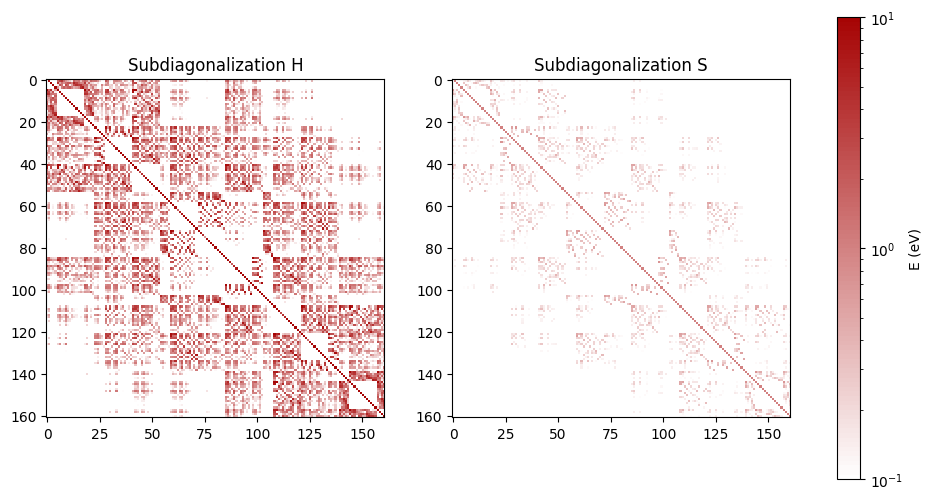

In [37]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao[0], S_lcao[0], a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao[0], Usub)[None, ...]
S_subdiagonal = rotate_matrix(S_lcao[0], Usub)[None, ...]

# Extract the bridge regions
bridge_region_H_sub = H_subdiagonal[0, bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_sub = S_subdiagonal[0, bridge_start:bridge_end, bridge_start:bridge_end]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonal H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonal S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


### Create embedded Hamiltonian

In [43]:
# Extract the basis for the subdiagonal region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonal species
active = {'C': [3], 'N': [3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

relevant_index = list(index_active_region)

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Remove periodic boundary conditions (PBC) from the device matrices
remove_pbc(device_basis, H_subdiagonal)
remove_pbc(device_basis, S_subdiagonal)


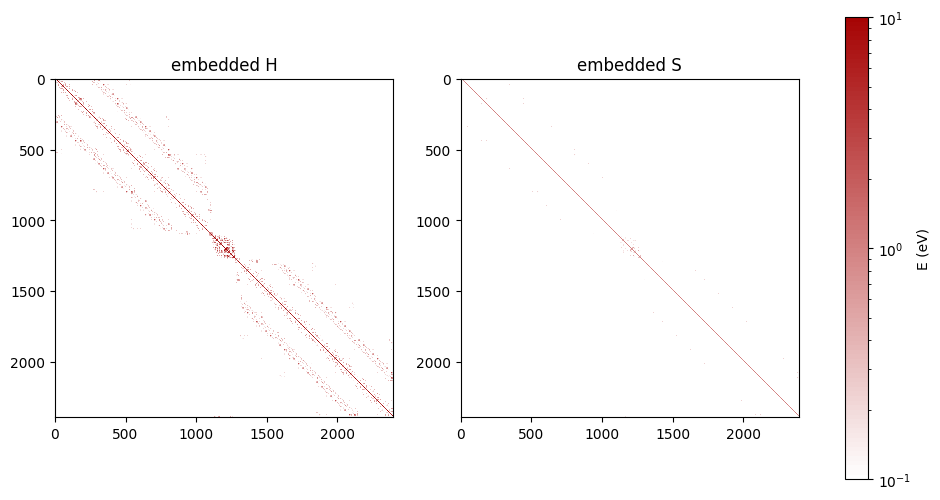

In [44]:
H_embedded, S_embedded = create_embedded_matrices(H_subdiagonal[0], S_subdiagonal[0], index_active_region)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonal H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_embedded), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("embedded H")

# Plot the subdiagonal S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_embedded), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("embedded S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()

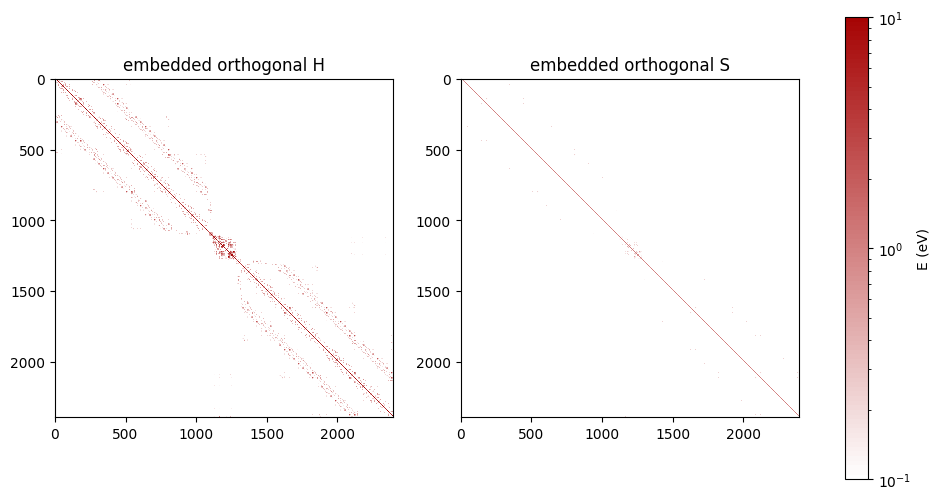

In [46]:
H_embedded_orthogonal, S_embedded_orthogonal = orthogonalize_AE_subspaces(H_subdiagonal[0], S_subdiagonal[0], index_active_region)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonal H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_embedded_orthogonal), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("embedded orthogonal H")

# Plot the subdiagonal S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_embedded_orthogonal), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("embedded orthogonal S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()

TODO if both the functions above work, look if there is way to combine the two functions without repeating code.

In [ ]:
# Initialize self-energy list for left and right leads, and the embedding self-energy
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# TODO How to compute self_energy of embedding region by providing Green's function of embedding (eqn B11, smart local orbitals)
# and the H_AE and H_EA of H_embedded_orthogonal  (eqn B8). 
gf.selfenergies.append(self_energy[2])

# When computing nodes in this case, what are the nodes